In [1]:
import numpy as np
import pandas as pd
import json
from collections import Counter
from IPython.display import SVG, display
from utils import *
from rdkit import Chem
from rdkit import Geometry
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor 
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

g:\MeTDDI_for_github\code\Visualization\mol_graph.py:2: UserWarning: ignore
  warnings.warn('ignore')


In [2]:
class DDI_Interpretation():
    def __init__(self,info_dict = r'mechanism_evidence_dict.npy',tokens_id_file = 'token_id.json'):
        self.info_dict = np.load(info_dict,allow_pickle=True).item()
        self.query_name = ''
        self.vocab = json.load(open(r'{}'.format(tokens_id_file),'r'))
        self.id_to_token = {value:key for key,value in self.vocab.items()}
    def summary(self):
        summary = {'Perpetrator':[],'Perp_SMILES':[],\
            'CYP_isoform inactivated':[],'Num_of Victim':[]}
        for key,value in self.info_dict.items():
            if key=='Tofacitinib': ### No related pairs that tofacitinib acts as a pepetrator,just filter it.
                continue
            else:
                summary['Perpetrator'].append(key)
                summary['Perp_SMILES'].append(value['SMILES'])
                summary['CYP_isoform inactivated'].append(value['CYP'])
                summary['Num_of Victim'].append(value.__len__()-1)
        return pd.DataFrame(summary)
    def get_topk_id(self,name,topk=1): 
        """Get topk motif id for each perpetrator
        name:Perpetrator name
        topK: only top1 and top2 is supported
        """
        if topk>2:
            raise 'only top1 and top2 is supported'
        perp_info = self.info_dict.get(name)
        all_att_ids = []
        for key,value in perp_info.items():
            if isinstance(value,dict):
                if topk>1:
                    temp_max_weights = []
                    top2_temp = value['max_weights_motif_top2']
                    for k in range(topk):
                        temp_max_weights.append(top2_temp[k][0])
                    all_att_ids.extend(set(temp_max_weights))
                else:
                    all_att_ids.append(value['max_weights_motif_top1'][0][0])
            else:
                continue
        return Counter(all_att_ids).most_common()
    def visualize(self,name,motif_id = None,img_size = 250,if_vis = True,\
                  svg = False,if_atom_weights = False,single_vis=False,index=1,weights_vis = []):
        """
        To visualize perpetrator
        Only support one motif_id each time.
        """
        if motif_id==None:
            return {'This is the top1 highlighted motifs':self.get_topk_id(name,1)}\
                ,{'This is the top2 highlighted motifs':self.get_topk_id(name,2)},'Choose one for visualization!!!'
        perp_info = self.info_dict.get(name)
        smiles = perp_info['SMILES']
        mol = Chem.MolFromSmiles(smiles) 
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
        atom_weights = []
        for key,value in perp_info.items():
            if isinstance(value,dict):
                if motif_id==value['max_weights_motif_top1'][0][0]:
                    atom_weights.append(value['atom_weights'])
            else:
                continue
        ### Compute average weights
        if single_vis:
            weights_to_vis = atom_weights[index]
        else:
            temp_weights = np.vstack(atom_weights).sum(axis=0)
            weights_to_vis = temp_weights/len(temp_weights)
        if len(weights_vis)!=0:
            weights_to_vis = weights_vis
        if if_vis:
            if svg: 
                drawer = rdMolDraw2D.MolDraw2DSVG(img_size, img_size)
                weights_to_vis = [float(i) for i in weights_to_vis]
                drawer = self.MapAtomFromWeights(mol,weights_to_vis,drawer)
                drawer.FinishDrawing()
                svg = drawer.GetDrawingText() 
                svg = svg.replace('svg:','')
                return SVG(svg)
            else:
                drawer = Chem.Draw.MolDraw2DCairo(img_size, img_size)
                weights_to_vis = [float(i) for i in weights_to_vis] 
                fig = SimilarityMaps.GetSimilarityMapFromWeights(
                mol,
                weights_to_vis,
                contourLines=0,alpha = 0.01,
                draw2d=drawer)   
                drawer.FinishDrawing() 
                img = self.show_cairo(drawer.GetDrawingText())
                return img 
        if if_atom_weights:
            return weights_to_vis
    def MapAtomFromWeights(self,mol,weights,draw2d,contourLines=0,sigma=None,gridResolution=0.06): 
        # A modified version from rdkit SimilarityMaps.GetSimilarityMapFromWeights
        """
        Generates the similarity map for a molecule given the atomic weights.

        Parameters:
        mol -- the molecule of interest
        colorMap -- the matplotlib color map scheme, default is custom PiWG color map
        scale -- the scaling: scale < 0 -> the absolute maximum weight is used as maximum scale
                                scale = double -> this is the maximum scale
        contourLines -- if integer number N: N contour lines are drawn
                        if list(numbers): contour lines at these numbers are drawn
        """
        if mol.GetNumAtoms() < 2:
            raise ValueError("too few atoms")
        mol = rdMolDraw2D.PrepareMolForDrawing(mol,addChiralHs=False)
        if not mol.GetNumConformers():
            rdDepictor.Compute2DCoords(mol)
        if sigma is None:
            if mol.GetNumBonds() > 0:
                bond = mol.GetBondWithIdx(0)
                idx1 = bond.GetBeginAtomIdx()
                idx2 = bond.GetEndAtomIdx()
                sigma = 0.3 * (mol.GetConformer().GetAtomPosition(idx1)-mol.GetConformer().GetAtomPosition(idx2)).Length()
            else:
                sigma = 0.3 * (mol.GetConformer().GetAtomPosition(0)-mol.GetConformer().GetAtomPosition(1)).Length()
            sigma = round(sigma, 2)
        sigmas = [sigma]*mol.GetNumAtoms()
        locs=[]
        for i in range(mol.GetNumAtoms()):
            p = mol.GetConformer().GetAtomPosition(i)
            locs.append(Geometry.Point2D(p.x,p.y))
        draw2d.ClearDrawing()
        ps = Draw.ContourParams()
        ps.fillGrid=True
        ps.gridResolution=gridResolution
        ps.extraGridPadding = 1
        Draw.ContourAndDrawGaussians(draw2d,locs,weights,sigmas,nContours=contourLines,params=ps)
        draw2d.drawOptions().clearBackground = False
        draw2d.DrawMolecule(mol)
        return draw2d
    def show_cairo(self,data):
        import io
        from PIL import Image
        bio = io.BytesIO(data)
        img = Image.open(bio)
        return img
    def hits_ratio(self,name,motif_id,topk=1):
        counts = self.get_topk_id(name=name,topk=topk)
        counts1 = self.get_topk_id(name=name,topk=1) 
        total_pairs = sum([i[1] for i in counts1])
        target_motif_pairs = sum([i[1] for i in counts if i[0]==motif_id])
        return {'Total_pairs:':total_pairs,\
                'Target_motif_pairs:':target_motif_pairs,'Hits_ratio:':f'{round(target_motif_pairs/total_pairs,3)*100} %'}

In [3]:
tokenizer = Mol_Tokenizer('token_id.json') 

In [4]:
### load pre-computed attention weights for all DDI pairs of collected chemicals
init_DDI = DDI_Interpretation('mechanism_evidence_dict.npy') 

In [5]:
# init_DDI.summary() 

In [6]:
# Case one: Tienilic acid, the output includes all the CYP inhibition mechanism the MeTDDI identified for the chemical.
# For example, the first tuple (4969, 84) in the output list includes the motif id (4969) and the number of DDI pair hit of this motif (84).
topk_id = init_DDI.get_topk_id('Tienilic acid',topk=1) 
topk_id 

[(4969, 84), (4078, 15), (1144, 5), (1021, 1)]

In [7]:
### We can transform motif id to motif token
motif_token = [(tokenizer.id_to_token[i[0]],i[1]) for i in topk_id] 
motif_token

[('c1ccsc1', 84), ('Cc', 15), ('CO', 5), ('CC', 1)]

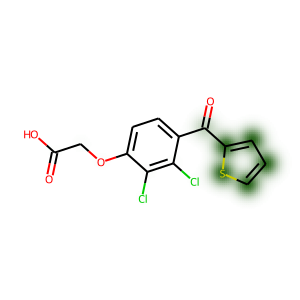

In [8]:
## then visualize the protential mechanism given specific motif id (the second param). Note that the output visualization is the 
## average attention weights of DDI pairs of the perpetrators.
init_DDI.visualize('Tienilic acid',motif_id = 4969,svg=False,img_size=300) 

In [9]:
### Compute hits ratio for the chemical with specific motif
init_DDI.hits_ratio('Tienilic acid',motif_id = 4969,topk=1)

{'Total_pairs:': 105, 'Target_motif_pairs:': 84, 'Hits_ratio:': '80.0 %'}

In [10]:
### case two: Ritonavir
topk_id = init_DDI.get_topk_id('Ritonavir',topk=1) 
topk_id

[(11901, 401), (7546, 25), (10862, 3)]

In [11]:
motif_token = [(tokenizer.id_to_token[i[0]],i[1]) for i in topk_id] 
motif_token

[('CN', 401), ('cC', 25), ('c1cscn1', 3)]

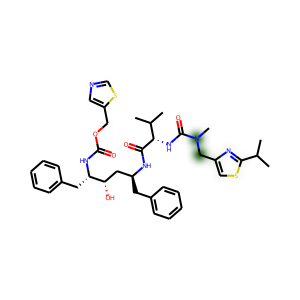

In [12]:
### visualize motif 'CN'
init_DDI.visualize('Ritonavir',motif_id = 11901 ,svg=False,img_size=300) 

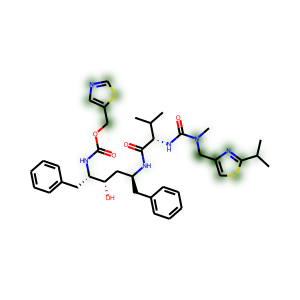

In [13]:
### visualize motif 'cC'
init_DDI.visualize('Ritonavir',motif_id = 7546,svg=False,img_size=300) 

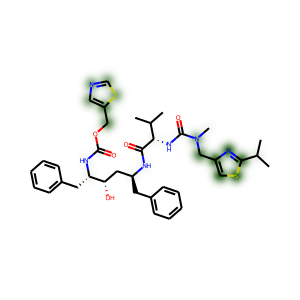

In [14]:
### visualize motif 'c1cscn1'
init_DDI.visualize('Ritonavir',motif_id = 10862,svg=False,img_size=300) 

In [15]:
### Hits ritio of motif 'CN'
init_DDI.hits_ratio('Ritonavir',motif_id = 11901,topk=1)

{'Total_pairs:': 429, 'Target_motif_pairs:': 401, 'Hits_ratio:': '93.5 %'}

In [16]:
### Case three：Cobicistat
topk_id = init_DDI.get_topk_id('Cobicistat',topk=1)
topk_id 

[(10862, 226), (11901, 116), (7546, 40)]

In [17]:
motif_token = [(tokenizer.id_to_token[i[0]],i[1]) for i in topk_id]
motif_token

[('c1cscn1', 226), ('CN', 116), ('cC', 40)]

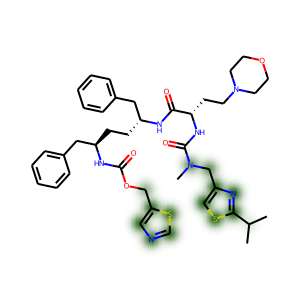

In [18]:
### visualize motif 'c1cscn1'
init_DDI.visualize('Cobicistat',motif_id = 10862,svg=False,img_size=300) 

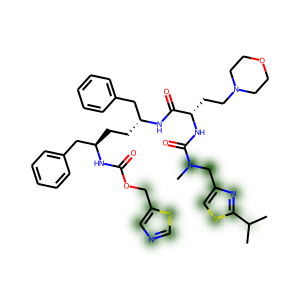

In [19]:
### visualize motif 'CN'
init_DDI.visualize('Cobicistat',motif_id = 11901,svg=False,img_size=300) 

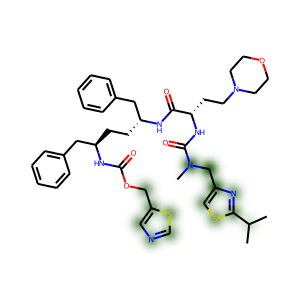

In [20]:
### visualize motif 'cC'
init_DDI.visualize('Cobicistat',motif_id = 7546,svg=False,img_size=300) 